# 2) Classification task

The following cells have all been run on Google Colab multiple times. This choice was mainly guided by the need of increasing the computational resources and reducing the necessary runtime to complete all the required tasks.

Since I performed multiple runs of the notebook in order to test different aspects of the Convolutional Neural Network, I had the chance to realize that the computational effort, runtime and the final Classification results are strongly affected by the type of device used. 

Google Colab randomly associates each session to an available GPU, therefore it's usually quite hard to gain coherent reproducible results. With the same definition of Train, Validation and Test sets, with the same distribution of labels in the three dataloaders and with the same CNN architecture and hyperparameters, the final results happened to be extremely different, sometimes opposite, depending on the number of workers in use and on the type of GPU and its memory.

The results reported in this notebook are strongly dependent on the device used and therefore not univocally reproducible.

In [17]:
#run on Colab
! pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
import torch
import torchvision
import torch.optim as optim
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.model_selection import GridSearchCV,KFold
from sklearn.metrics import confusion_matrix
from optuna.visualization import plot_param_importances

import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import optuna
import time
import seaborn as sns


In [19]:
#set seed
seed = 5630
torch.manual_seed(seed)

#Select device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

## 2.1) Preprocessing



### 2.1.1) Download, Datasets and Dataloaders

I downloaded the $\texttt{train_dataset}$ and $\texttt{test_dataset}$ and transformed them into tensors by applying the usual $\texttt{ToTensor()}$ transformation.

I divided the initial Training set into Train (75%) and Validation(25%); other combinations of percentages have been tested (80% Train 20% Val, 70% Train and 30% Val) but the results are not strongly dependent on these divisions.

Moreover, I created Dataloader objects out of the previously mentioned Datasets, making sure to properly set the $\texttt{batch_size}$ dimension and the $\texttt{num_workers}$: these parameters should be tuned depending on the characteristics of the device in which the code is going to run.

Eventually I printed some examples of the data I am dealing with and the amount of samples present in each set.


In [4]:
#define transformations to apply to datasets
dataset_transforms = transforms.Compose([transforms.ToTensor()])

###DATASETS
train_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, 
                                                  transform=dataset_transforms, download=True)
test_dataset  = torchvision.datasets.FashionMNIST('classifier_data', train=False, 
                                                  transform=dataset_transforms, download=True)

#different classes
label_names=['t-shirt','trouser','pullover','dress','coat','sandal','shirt',
             'sneaker','bag','boot']
n_classes = len(label_names)
print("Number of Different Classes:",n_classes)

#define training, validation and test dimensions
train_percentage = 0.75
train_dim = int(train_percentage*len(train_dataset))
val_dim = int(len(train_dataset) - train_dim)
test_dim = len(test_dataset)

#split training and validation data
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_dim, val_dim])
print("Dimension of Training Set:",train_dim,"\nDimension of Validation Set:", val_dim,
      "\nDimension of Test Set:",test_dim)

###DATALOADERS
batch_size=1000
train_dataloader = DataLoader(train_dataset, batch_size, num_workers=4,shuffle=True)
val_dataloader = DataLoader(val_dataset, len(val_dataset), num_workers=4, shuffle=True)
test_dataloader = DataLoader(test_dataset, len(test_dataset), num_workers=4,shuffle=False)


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting classifier_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to classifier_data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting classifier_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to classifier_data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting classifier_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to classifier_data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting classifier_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to classifier_data/FashionMNIST/raw

Number of Different Classes: 10
Dimension of Training Set: 45000 
Dimension of Validation Set: 15000 
Dimension of Test Set: 10000


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


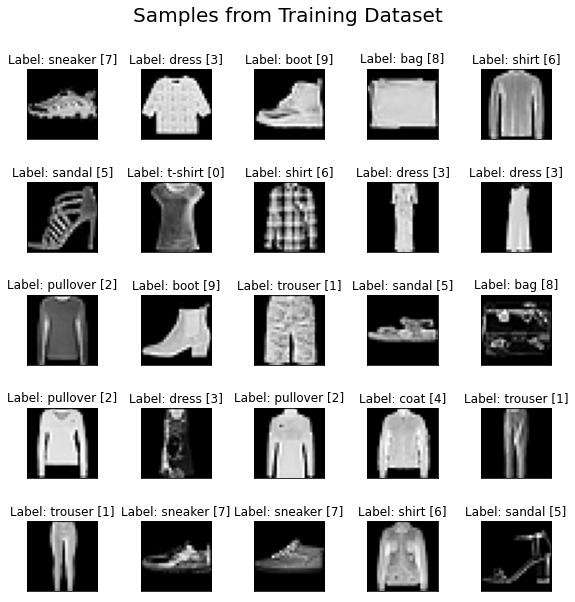

In [ ]:
###PLOT SOME EXAMPLES
fig, axs = plt.subplots(5, 5, figsize=(8,8))

for ax in axs.flatten():
    
    #select random sample
    img, label = random.choice(train_dataset)
    img = img.squeeze(0)
    
    #show
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title(f'Label: {label_names[label]} [{label}]')
    ax.set_xticks([])
    ax.set_yticks([])
plt.suptitle("Samples from Training Dataset",fontsize=20,x=0.5,y=1.05)    
plt.tight_layout()

### 2.1.2) Data Distribution

I decided to dedicate a section of the notebook to study the distribution of the ten different classes in each of the three Datasets in use.

I counted the occurences of each class in each dataset, represented their values as percentages with respect to the overall number of sample in each dataset and compared them to the Uniform Ditribution. 

As we can see from the plots below, the Test Dataset always has the same amount of samples for each class since, after its download, it is not undergoing any further division. The Training and Validation sets instead always present different distribution, slightly far from the Uniform one, because of different division of the samples and their reshuffling.

It is important to perform this check because a Training set which doesn't present a reasonable amount of all the labels available might correspond to a non optimal learning: if the amount of data of a specific class is much higher in the Validation Set rather than in the Training Set, the NN might not have enough information to properly learn all the features corresponding to that class and the final results would be eventually negatively influenced.


In [ ]:
#for each class
count_train = []
count_val = []
count_test = []

for index, class_name in enumerate(label_names):

    index_tensor = torch.tensor(np.repeat(index,batch_size))

    #TRAIN DATALOADER
    count = 0
    for batch in train_dataloader:
        #list of labels
        label_batch = batch[1]
        count = count + torch.sum(label_batch==index_tensor)
    count_train.append(count)

    index_tensor = torch.tensor(np.repeat(index,val_dim))

    #VAL DATALOADER
    count = 0
    for batch in val_dataloader:
        #list of labels
        label_batch = batch[1]
        count = count + torch.sum(label_batch==index_tensor)

    count_val.append(count)

    index_tensor = torch.tensor(np.repeat(index,10000))

    #TEST DATALOADER
    count = 0
    for batch in test_dataloader:
        #list of labels
        label_batch = batch[1]
        count = count + torch.sum(label_batch==index_tensor)

    count_test.append(count)


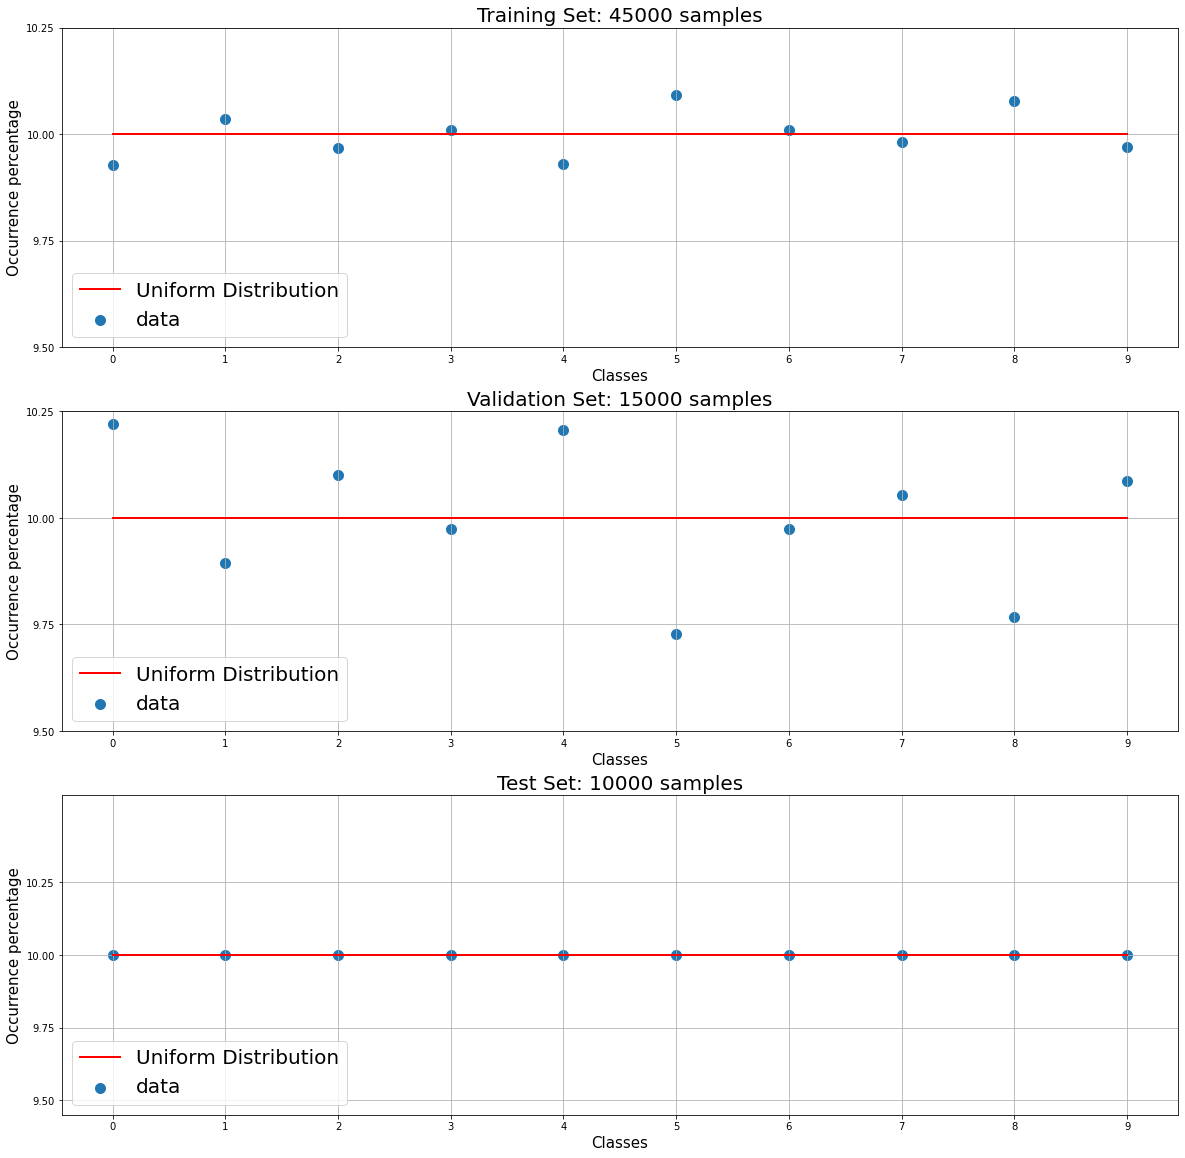

In [ ]:
#plot distribution of datasets
fig,ax = plt.subplots(3,1,figsize=(20,20))

sets = ['Training Set','Validation Set','Test Set']
counts = [count_train,count_val,count_test]
dims = [train_dim,val_dim,test_dim]

for i,s in enumerate(sets):

    #normalize
    count = counts[i]/np.sum(counts[i])

    ax[i].scatter(np.arange(0,10),count*100,s=100,label="data")
    ax[i].set_title(f"{s}: {dims[i]} samples",fontsize=20)
    ax[i].plot(np.arange(0,10),np.repeat(10,10),color='red',linewidth=2,label="Uniform Distribution")
    ax[i].set_xlabel("Classes",fontsize=15)
    ax[i].set_ylabel("Occurrence percentage",fontsize=15)
    ax[i].set_xticks(np.arange(0,10))
    ax[i].set_yticks(np.arange(9.5,10.5,0.25))
    ax[i].grid()
    ax[i].legend(fontsize=20,loc="lower left")

plt.show()


## 2.2) Classes and functions

In the following cells I'm defining a series of functions and classes that I will use throughout the whole notebook.

The Convolutional Neural Network Class definition is not present in this cell because it will be used for different purposes in the following  sections and a unique definition of it would be too limiting.

The training funcion works almost in the same way as the one defined in the Regression task. The difference this time is that I chose not to perform cross validation on the data in order to limit the computational effort of the code.

Its fuctioning follows these main steps:

* 1) A loop is performed on the total number of epochs.

* 2) For each epoch the NN is set into training mode and the Train Dataloader is scanned batch per batch.

* 3) For each training batch, data and labels are separately stored. The output of the data is computed and its distance from the actual labels is measured by means of the loss function ($\texttt{nn.CrossEntropyLoss()}$). The NN weights are then updated accordingly through backpropagation and the batch training loss value is stored into a list.

* 4) The NN is then moved into evaluation mode and the Validation Dataloader is scanned batch per batch. For each batch both the output and the loss are calculated, but the weights are not being updated to improve the NN efficiency.

* 5) Eventually the mean loss values for all the batches in the training data and in the validation data are separately stored in two empty lists. These data will be used to plot and study the learning curves of the CNN architecture.

In [5]:
def new_training(NN, num_epochs, loss_function, optimizer,verbose=False,test=False):
    
    #Learning Curve values
    train_loss_log = []
    val_loss_log = []
    
    #iteration over epochs
    for epoch_num in range(num_epochs):
        
        if verbose:print("Epoch:",epoch_num)
        
        # Training mode
        NN.train() 

        train_loss = []
        for sampled_batch in train_dataloader: 

            #move data to device
            x_batch = sampled_batch[0].to(device)
            label_batch = sampled_batch[1].to(device)

            #Compute output of NN
            out = NN(x_batch)

            #Compute loss with loss_function
            loss = loss_function(out, label_batch)

            #Backpropagation
            NN.zero_grad()
            loss.backward()

            #Update the weights according to the optimizer
            optimizer.step()

            #Save train loss for this batch
            loss_batch = loss.detach().cpu().numpy()
            train_loss.append(loss_batch)
            
        
        if verbose: print("TRAINING LOSS:",np.mean(train_loss))
            
        #Evaluation mode 
        NN.eval() 
        
        #Validation or Test set according to input flag
        if test:
            dataloader = test_dataloader
        else:
            dataloader = val_dataloader

        with torch.no_grad():

            val_loss = []
            for sampled_batch in dataloader:

                #Move data to device
                x_batch = sampled_batch[0].to(device)
                label_batch = sampled_batch[1].to(device)

                #Compute output of NN
                out = NN(x_batch)

                #Compute loss with loss_function
                loss = loss_function(out, label_batch)

                #Save val loss for this batch
                loss_batch = loss.detach().cpu().numpy()
                val_loss.append(loss_batch)
                
            if verbose: print("VALIDATION LOSS:",np.mean(val_loss))
      
        #save mean loss values for each epoch    
        train_loss_log.append(np.mean(train_loss))
        val_loss_log.append(np.mean(val_loss))
    
    print("Network Trained")
        
    return [train_loss_log, val_loss_log] 

The following is a simple function that takes as input the training and validation loss lists and plot them together in the same figure, in order to better visualize the learning proces of the CNN.

In [6]:
def plot_learningcurves(train, val):
    
    # Plot losses
    plt.figure(figsize=(12,8))
    plt.semilogy(val, label='Validation loss')
    plt.semilogy(train, label='Train loss')
    plt.title(f"Learning Curves for CNN:",fontsize=20)
    plt.xlabel('Epochs',fontsize=20)
    plt.ylabel('Loss',fontsize=20)
    plt.grid()
    plt.legend(fontsize=20)
    plt.show()

The $\texttt{pooling_dim}$ function will allow me to keep track of the dimension of flattened linear layer after the convolutional section of the Neural Network. 

It performs a for loop over each convolutional layer in the architecture. For each layer it counts how many data are being collected: starting from a 28x28 pixel image, each channel of the following layer will have a different dimension depending on the $\texttt{kernel_size}$ (only 3x3 or 5x5 in this notebook) and on the $\texttt{stride}$ pace.
Between each convolutional layer, the dimension of each channel is updated accordingly.

Eventually the final flattened layer will have a total number of neurons corresponding to the number of final channels times the square of the dimension of each channel halved (due to the MaxPooling of stride too performed between the convolutional and linear sections). The second linear layer, when present is set to have exactely one half of the neurons present in the first linear layer.



In [7]:
def pooling_dim(n_cl,channel, kernel_size,padding=0,stride=1):
        
    dim = 28

    #for each convolutional layer update dimension
    for i in range(n_cl):
        dim = len(np.arange(0,dim-kernel_size+1,stride))
        
    #update dimensions of linear layers
    first_linear = int(channel*(dim/2)**2)
    second_linear = int(first_linear/2)

    return [first_linear,second_linear]
 

The following function allows me to plot the confusion matrix between the actual labels and the predicted ones from the Convolutional Neural Network. The predicted labels are computed exactely like in the evaluation section of the $\texttt{new_training}$ function; by applying the CNN to the batch data, the output array is computed. The predicted label will correspond to the index of the output neuron corresponding to the maximum output value.


The input arguments $\texttt{dataloader}$ and $\texttt{dataset}$ allow me to choose on which set of data the confusion matrix is computed, so to be able to visualize the performances both at the Validation and at the Testing level. 


In [8]:
def plot_confusion_matrix(model,dataloader,dataset,params_dict):
        
    #set params
    loss_fn = nn.CrossEntropyLoss()

    #model's prediction
    prediction = []
    preds_correct = 0
    len_preds_correct = 0

    #evaluation mode
    model.eval() 
    with torch.no_grad(): 
        for sample_batched in dataloader:
            x_batch = sample_batched[0].to(device)
            label_batch = sample_batched[1].to(device)

            out = model(x_batch)
            loss = loss_fn(out, label_batch)
            loss_batch = loss.detach().cpu().numpy()
            
            preds = torch.max(out,1)[1]
            prediction.append(preds.cpu().numpy())
            preds_correct += torch.sum(preds==label_batch.data)
            len_preds_correct += len(label_batch)
    
        accuracy = preds_correct.detach().cpu().numpy()/len_preds_correct
    
    #compare predictions and true values
    y_pred = np.concatenate(prediction).ravel()
    y_true = np.array([x[1] for x in dataset])

    #create confusion matrix
    matrix = confusion_matrix(y_true, y_pred)
    
    #plot
    plt.figure(figsize = (9,7))
    sns.heatmap(matrix/1000, annot=True, fmt =  "1.2f", cmap='Blues'  )
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title('Confusion matrix', size=16)
    plt.show()

## 2.3) Compare Architectures


As a first step, I decided to compare four different Convolutional Neural Network Architectures, in order to have a general idea about their learning behaviour.

This kind of study is more of a qualitative evaluation of the CNNs. I was not expecting to retrieve meaningful results, since all the hyperparameters have just been set in a fixed but random manner, therefore they are not optimized a priori for this classification task.

I decided to test the following architectures:

|Architecture | Channels Conv 1 | Channels Conv 2 | Channels Conv 3 | Max Pooling 2 | Linear 1 | Linear 2 | Output |
| --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | 4 | 8 | / | TRUE | 1152 | / | 10 |
| 2 | 4 | 8 | / | TRUE | 1152 | 576 | 10 |
| 3 | 4 | 8 | 16 | TRUE | 1936 | / | 10 |
| 4 | 4 | 8 | 16 | TRUE | 1152 | 968 | 10 |

For all the previous, the following parameters remained fixed:

| Loss Function | Optimizer | Epochs | Stride | Padding |
| --- | --- | --- | --- | --- |
| CrossEntropyLoss | Adam | 20 | 1 | 0 | 


I stored the training and validation losses for all the architeectures and eventually compared their learning curves. I also stored the runtime used to train each architecture.


In [ ]:
train_losses = []
val_losses = []
times = []
archs = []

### 2.3.1) Arch 1

In [ ]:
class CNN_1(nn.Module):
    
    def __init__(self,params_dict):
        super().__init__()
        
        ###Read parameters from dict
        cl_out1 = params_dict["cl_out1"]
        cl_out2 = params_dict["cl_out2"]
        
        ### Convolutional section
        self.conv = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(in_channels=1, out_channels=cl_out1, kernel_size=3,
                                  stride=1, padding=0),nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(in_channels=cl_out1, out_channels=cl_out2, kernel_size=3,
                        stride=1, padding=0),nn.ReLU(True),          
        )
   
        #MAX POOLING of stride 2
        #update dimensions of linear layers
        first_linear,second_linear = pooling_dim(2, cl_out2,3,padding=0,stride=1);
        
        ###Linear Section
        self.linear = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=first_linear, out_features=n_classes),nn.ReLU(True),
        )
        
    def forward(self, x):
        x = self.conv(x) 
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x,1)
        x = self.linear(x)
        return x

In [ ]:
#TIME CONSUMING CELL
start_time = time.time()

#Dictionary Parameters
params_NN_1 = {
    'cl_out1' : 4,
    'cl_out2' : 8
}

#initialize NN
NN_1 = CNN_1(params_NN_1)

#move NN to device
NN_1.to(device)

# Define the optimizer
optimizer = optim.Adam(NN_1.parameters())

#train NN
train_loss_1, val_loss_1 = new_training(NN_1, num_epochs=20,loss_function=nn.CrossEntropyLoss(),
                                     optimizer=optimizer,verbose=True)

#store loss values
train_losses.append(train_loss_1)
val_losses.append(val_loss_1)

#store architecture
architecture_1 = {
    'cl' : [params_NN_1['cl_out1'],params_NN_1['cl_out2']],
    'll' : [pooling_dim(2, params_NN_1['cl_out2'], 3,padding=0,stride=1)[0]]
}

archs.append(architecture_1)
print(architecture_1)

#store time value
time_1 = (time.time() - start_time)
times.append(time_1)
print("--- %s seconds ---" % time_1)

#clear GPU memory
torch.cuda.empty_cache()

Epoch: 0
TRAINING LOSS: 2.1969786
VALIDATION LOSS: 2.033932
Epoch: 1
TRAINING LOSS: 1.9299576
VALIDATION LOSS: 1.884191
Epoch: 2
TRAINING LOSS: 1.8562895
VALIDATION LOSS: 1.8446636
Epoch: 3
TRAINING LOSS: 1.8231266
VALIDATION LOSS: 1.8214048
Epoch: 4
TRAINING LOSS: 1.802599
VALIDATION LOSS: 1.8040855
Epoch: 5
TRAINING LOSS: 1.7894384
VALIDATION LOSS: 1.7944959
Epoch: 6
TRAINING LOSS: 1.7814828
VALIDATION LOSS: 1.787634
Epoch: 7
TRAINING LOSS: 1.7750528
VALIDATION LOSS: 1.7810379
Epoch: 8
TRAINING LOSS: 1.7689694
VALIDATION LOSS: 1.7757157
Epoch: 9
TRAINING LOSS: 1.7648118
VALIDATION LOSS: 1.7712919
Epoch: 10
TRAINING LOSS: 1.761018
VALIDATION LOSS: 1.7721176
Epoch: 11
TRAINING LOSS: 1.7593387
VALIDATION LOSS: 1.7653829
Epoch: 12
TRAINING LOSS: 1.7551664
VALIDATION LOSS: 1.7618353
Epoch: 13
TRAINING LOSS: 1.7521391
VALIDATION LOSS: 1.7578704
Epoch: 14
TRAINING LOSS: 1.7493405
VALIDATION LOSS: 1.7561293
Epoch: 15
TRAINING LOSS: 1.7479695
VALIDATION LOSS: 1.7531762
Epoch: 16
TRAINING LOSS

### 2.3.2) Arch 2

In [ ]:
class CNN_2(nn.Module):
    
    def __init__(self,params_dict):
        super().__init__()
        
        ###Read parameters from dict
        cl_out1 = params_dict["cl_out1"]
        cl_out2 = params_dict["cl_out2"]
        
        ### Convolutional section
        self.conv = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(in_channels=1, out_channels=cl_out1, kernel_size=3,
                                  stride=1, padding=0),nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(in_channels=cl_out1, out_channels=cl_out2, kernel_size=3,
                        stride=1, padding=0),nn.ReLU(True),          
        )
        
        #MAX POOLING of stride 2
        #update dimensions of linear layers
        first_linear,second_linear = pooling_dim(2,cl_out2, 3,padding=0,stride=1);
        
        ###Linear Section
        self.linear = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=first_linear, out_features=second_linear),nn.ReLU(True),
            # Second linear layer
            nn.Linear(in_features=second_linear, out_features=n_classes),nn.ReLU(True)
        )
        
    def forward(self, x):
        x = self.conv(x) 
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x,1)
        x = self.linear(x)
        return x

In [ ]:
#TIME CONSUMING CELL
start_time = time.time()

#Dictionary Parameters
params_NN_2 = {
    'cl_out1' : 4,
    'cl_out2' : 8
}

#initialize NN
NN_2 = CNN_2(params_NN_2)

#move NN to device
NN_2.to(device)

# Define the optimizer
optimizer = optim.Adam(NN_2.parameters())

#train NN
train_loss_2, val_loss_2 = new_training(NN_2, num_epochs=20,loss_function=nn.CrossEntropyLoss(),
                                     optimizer=optimizer,verbose=True)

train_losses.append(train_loss_2)
val_losses.append(val_loss_2)

#store architecture
architecture_2 = {
    'cl' : [params_NN_2['cl_out1'],params_NN_2['cl_out2']],
    'll' : pooling_dim(2, params_NN_2['cl_out2'], 3, padding=0,stride=1)
}

archs.append(architecture_2)
print(architecture_2)

#store time
time_2 = (time.time() - start_time)
times.append(time_2)
print("--- %s seconds ---" % time_2)

#clear GPU memory
torch.cuda.empty_cache()

Epoch: 0
TRAINING LOSS: 1.844459
VALIDATION LOSS: 1.4440844
Epoch: 1
TRAINING LOSS: 1.3626938
VALIDATION LOSS: 1.2985426
Epoch: 2
TRAINING LOSS: 1.2843633
VALIDATION LOSS: 1.2479674
Epoch: 3
TRAINING LOSS: 1.247307
VALIDATION LOSS: 1.2206018
Epoch: 4
TRAINING LOSS: 1.2220845
VALIDATION LOSS: 1.2036028
Epoch: 5
TRAINING LOSS: 1.2064457
VALIDATION LOSS: 1.1890984
Epoch: 6
TRAINING LOSS: 1.1967384
VALIDATION LOSS: 1.1781526
Epoch: 7
TRAINING LOSS: 1.1838938
VALIDATION LOSS: 1.1666553
Epoch: 8
TRAINING LOSS: 1.1735803
VALIDATION LOSS: 1.1632792
Epoch: 9
TRAINING LOSS: 1.1669276
VALIDATION LOSS: 1.154952
Epoch: 10
TRAINING LOSS: 1.1595315
VALIDATION LOSS: 1.1546212
Epoch: 11
TRAINING LOSS: 1.1548449
VALIDATION LOSS: 1.1508833
Epoch: 12
TRAINING LOSS: 1.1461092
VALIDATION LOSS: 1.1434116
Epoch: 13
TRAINING LOSS: 1.1393427
VALIDATION LOSS: 1.1326596
Epoch: 14
TRAINING LOSS: 1.132901
VALIDATION LOSS: 1.1309606
Epoch: 15
TRAINING LOSS: 1.1308388
VALIDATION LOSS: 1.1380091
Epoch: 16
TRAINING LOS

### 2.3.3) Arch 3

In [ ]:
class CNN_3(nn.Module):
    
    def __init__(self,params_dict):
        super().__init__()
        
        ###Read parameters from dict
        cl_out1 = params_dict["cl_out1"]
        cl_out2 = params_dict["cl_out2"]
        cl_out3 = params_dict["cl_out3"]
        
        ### Convolutional section
        self.conv = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(in_channels=1, out_channels=cl_out1, kernel_size=3,
                        stride=1, padding=0),nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(in_channels=cl_out1, out_channels=cl_out2, kernel_size=3,
                        stride=1, padding=0),nn.ReLU(True),  
            # Third convolutional layer
            nn.Conv2d(in_channels=cl_out2, out_channels=cl_out3, kernel_size=3,
                        stride=1, padding=0),nn.ReLU(True),  
        )
   
        #MAX POOLING of stride 2
        #update dimensions of linear layers
        first_linear,second_linear = pooling_dim(3,cl_out3, 3,padding=0,stride=1);
        
        ###Linear Section
        self.linear = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=first_linear, out_features=n_classes),nn.ReLU(True),
        )
        
    def forward(self, x):
        x = self.conv(x) 
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x,1)
        x = self.linear(x)
        return x

In [ ]:
#TIME CONSUMING CELL
start_time = time.time()

#Dictionary Parameters
params_NN_3 = {
    'cl_out1' : 4,
    'cl_out2' : 8,
    'cl_out3' : 16
}

#initialize NN
NN_3 = CNN_3(params_NN_3)

#move NN to device
NN_3.to(device)

# Define the optimizer
optimizer = optim.Adam(NN_3.parameters())

#train NN
train_loss_3, val_loss_3 = new_training(NN_3, num_epochs=20,loss_function=nn.CrossEntropyLoss(),
                                     optimizer=optimizer,verbose=True)

#store losses
train_losses.append(train_loss_3)
val_losses.append(val_loss_3)

#store architecture
architecture_3 = {
    'cl' : [params_NN_3['cl_out1'],params_NN_3['cl_out2'],params_NN_3['cl_out3']],
    'll' : pooling_dim(3, params_NN_3['cl_out3'], 3, padding=0,stride=1)[0]
}
archs.append(architecture_3)
print(architecture_3)

#store time
time_3 = time.time() - start_time
times.append(time_3)
print("--- %s seconds ---" % time_3)

#clear GPU memory
torch.cuda.empty_cache()

Epoch: 0
TRAINING LOSS: 1.8090444
VALIDATION LOSS: 1.4179375
Epoch: 1
TRAINING LOSS: 1.3404323
VALIDATION LOSS: 1.3210921
Epoch: 2
TRAINING LOSS: 1.2909882
VALIDATION LOSS: 1.2946233
Epoch: 3
TRAINING LOSS: 1.2705191
VALIDATION LOSS: 1.2779291
Epoch: 4
TRAINING LOSS: 1.254918
VALIDATION LOSS: 1.2638845
Epoch: 5
TRAINING LOSS: 1.2433413
VALIDATION LOSS: 1.25906
Epoch: 6
TRAINING LOSS: 1.2374732
VALIDATION LOSS: 1.2525946
Epoch: 7
TRAINING LOSS: 1.2313054
VALIDATION LOSS: 1.2464777
Epoch: 8
TRAINING LOSS: 1.2300458
VALIDATION LOSS: 1.2443204
Epoch: 9
TRAINING LOSS: 1.2278905
VALIDATION LOSS: 1.2421768
Epoch: 10
TRAINING LOSS: 1.2227573
VALIDATION LOSS: 1.2410542
Epoch: 11
TRAINING LOSS: 1.2202189
VALIDATION LOSS: 1.2407606
Epoch: 12
TRAINING LOSS: 1.2180549
VALIDATION LOSS: 1.2385113
Epoch: 13
TRAINING LOSS: 1.2145356
VALIDATION LOSS: 1.234765
Epoch: 14
TRAINING LOSS: 1.2128801
VALIDATION LOSS: 1.2359025
Epoch: 15
TRAINING LOSS: 1.2110442
VALIDATION LOSS: 1.2344093
Epoch: 16
TRAINING LOS

### 2.3.4) Arch 4


In [ ]:
class CNN_4(nn.Module):
    
    def __init__(self,params_dict):
        super().__init__()
        
        ###Read parameters from dict
        cl_out1 = params_dict["cl_out1"]
        cl_out2 = params_dict["cl_out2"]
        cl_out3 = params_dict["cl_out3"]
    
        ### Convolutional section
        self.conv = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(in_channels=1, out_channels=cl_out1, kernel_size=3,
                                  stride=1, padding=0),nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(in_channels=cl_out1, out_channels=cl_out2, kernel_size=3,
                        stride=1, padding=0),nn.ReLU(True),  
            # Third convolutional layer
            nn.Conv2d(in_channels=cl_out2, out_channels=cl_out3, kernel_size=3,
                        stride=1, padding=0),nn.ReLU(True),  
        )
   
        ###Dropout
        #self.dropout1 = nn.Dropout(dropout)
        
        #MAX POOLING of stride 2
        #update dimensions of linear layers
        first_linear,second_linear = pooling_dim(3, cl_out3, 3,padding=0,stride=1);
        
        ###Linear Section
        self.linear = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=first_linear, out_features=second_linear),nn.ReLU(True),
            # Second linear layer
            nn.Linear(in_features=second_linear, out_features=n_classes),nn.ReLU(True)
        )
        
        
    def forward(self, x):
        x = self.conv(x) 
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x,1)
        x = self.linear(x)
        return x

In [ ]:
#TIME CONSUMING CELL
start_time = time.time()

#Dictionary Parameters
params_NN_4 = {
    'cl_out1' : 4,
    'cl_out2' : 8,
    'cl_out3' : 16
}

#initialize NN
NN_4 = CNN_4(params_NN_4)

#move NN to device
NN_4.to(device)

# Define the optimizer
optimizer = optim.Adam(NN_4.parameters())

#train NN
train_loss_4, val_loss_4 = new_training(NN_4, num_epochs=20,loss_function=nn.CrossEntropyLoss(),
                                     optimizer=optimizer,verbose=True)
#store losses
train_losses.append(train_loss_4)
val_losses.append(val_loss_4)

#architecture
architecture_4 = {
    'cl' : [params_NN_4['cl_out1'],params_NN_4['cl_out2'],params_NN_4['cl_out3']],
    'll' : pooling_dim(3, params_NN_4['cl_out3'], 3, padding=0,stride=1)
}
archs.append(architecture_4)

#store time
time_4 = time.time() - start_time
times.append(time_4)
print("--- %s seconds ---" % time_4)

#clear GPU memory
torch.cuda.empty_cache()

Epoch: 0
TRAINING LOSS: 1.500063
VALIDATION LOSS: 1.106821
Epoch: 1
TRAINING LOSS: 1.0446409
VALIDATION LOSS: 1.0254049
Epoch: 2
TRAINING LOSS: 0.99269485
VALIDATION LOSS: 0.994783
Epoch: 3
TRAINING LOSS: 0.953626
VALIDATION LOSS: 0.9533133
Epoch: 4
TRAINING LOSS: 0.91720575
VALIDATION LOSS: 0.92370397
Epoch: 5
TRAINING LOSS: 0.89906377
VALIDATION LOSS: 0.9133739
Epoch: 6
TRAINING LOSS: 0.883504
VALIDATION LOSS: 0.90865654
Epoch: 7
TRAINING LOSS: 0.8773484
VALIDATION LOSS: 0.89416146
Epoch: 8
TRAINING LOSS: 0.8640889
VALIDATION LOSS: 0.8962904
Epoch: 9
TRAINING LOSS: 0.85576534
VALIDATION LOSS: 0.88718235
Epoch: 10
TRAINING LOSS: 0.8563497
VALIDATION LOSS: 0.88306534
Epoch: 11
TRAINING LOSS: 0.84619194
VALIDATION LOSS: 0.8764129
Epoch: 12
TRAINING LOSS: 0.84329724
VALIDATION LOSS: 0.8692871
Epoch: 13
TRAINING LOSS: 0.83493906
VALIDATION LOSS: 0.8746872
Epoch: 14
TRAINING LOSS: 0.82857007
VALIDATION LOSS: 0.86580896
Epoch: 15
TRAINING LOSS: 0.82356626
VALIDATION LOSS: 0.8747989
Epoch: 1

### 2.3.5) Comparison plot

As expected, the following comparison is not sufficiently informative. There is no way to understand a priori which architecture would better fit my Classification task. The learning process is depending on a whole series of different parameters and the number of convolutional/linear layers looks to be not relevant at this level of my study.

As a dummy, I wanted to verify if the number of convolutional/linear layers would present any lower or upper bound beyond which the CNN would not work properly. Of course if one decides to perform such a study, a wider range of different architectures should be explored in order to be able to hopefully retrieve some significant results.
Also, a qualitative comparison of the learning curves is not the most informative method to compare the effectiveness of the architectures.

In my case, a part from some expected differences in the stability of the curves, their behaviours are substantially equal. The number of epochs is not high enough for any of the architecture to reach a satisfying loss result, nonetheless the last architecture happens to be the fastest in gaining a loss value smaller than 1.

I am gonna keep this architecture for the rest of the notebook and properly tune its hyperparameters.




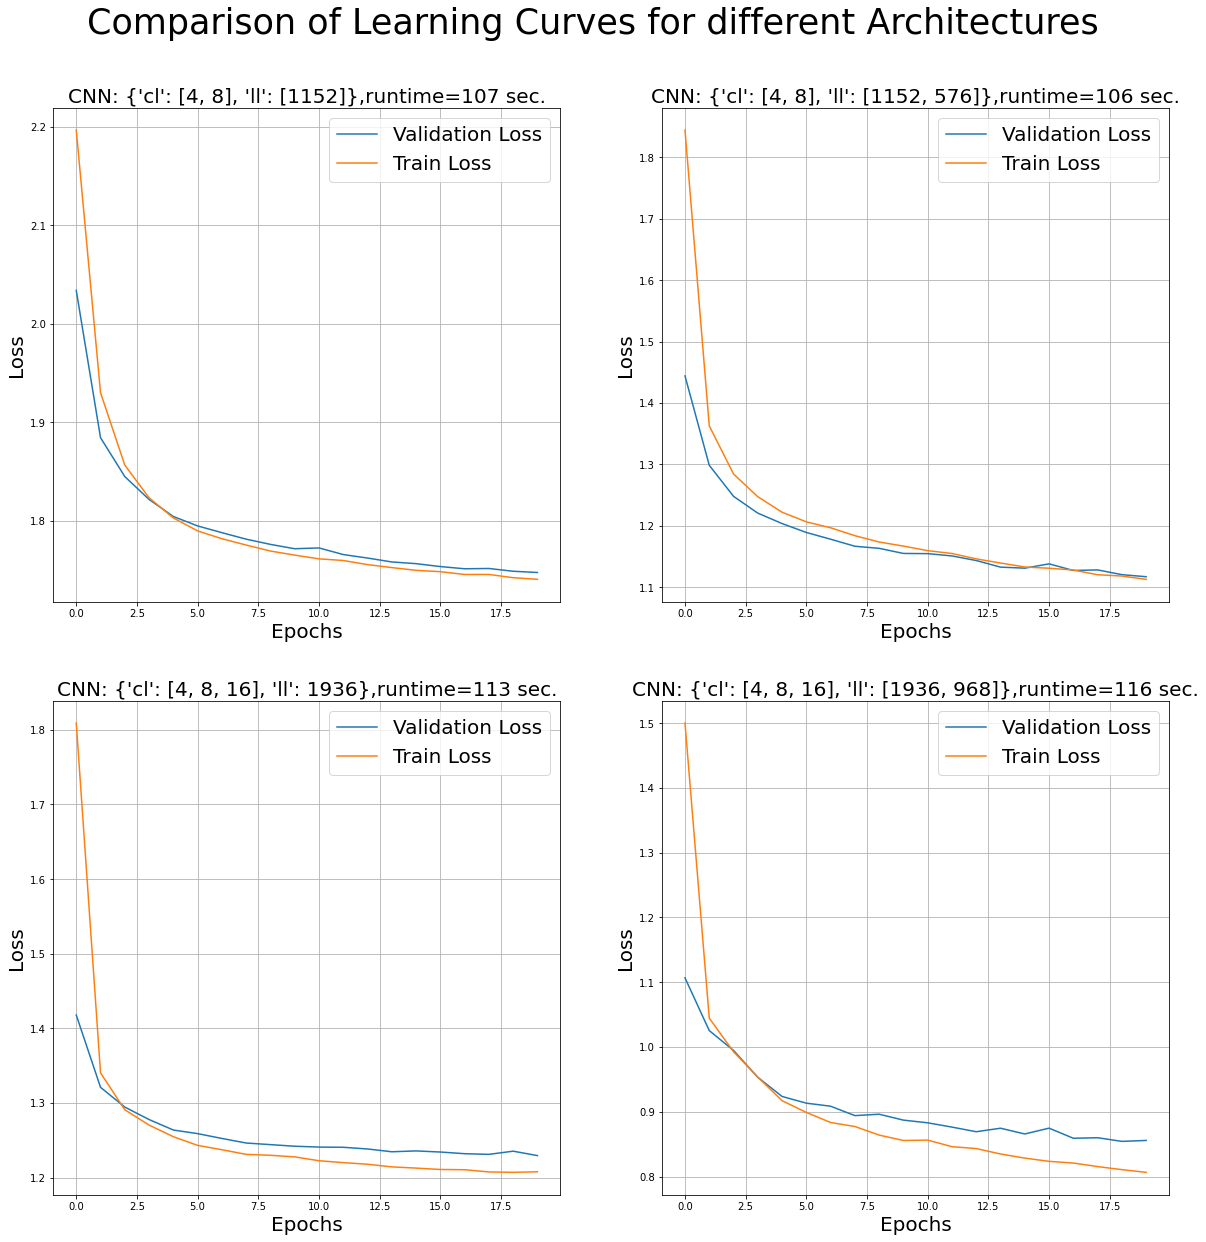

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(20,20))
for i in range(2):
    for j in range(2):
        
        #select data from storage lists
        arch = archs[2*i+j]
        val = val_losses[2*i+j]
        train = train_losses[2*i+j]
        t = times[2*i+j]
        epochs = np.arange(0,20)
    
        ax[i,j].plot(epochs,val,label="Validation Loss")
        ax[i,j].plot(epochs,train, label="Train Loss")
        ax[i,j].set_title(f"CNN: {arch},runtime={int(t)} sec.",fontsize=20)
        ax[i,j].set_xlabel('Epochs',fontsize=20)
        ax[i,j].set_ylabel('Loss',fontsize=20)
        ax[i,j].legend(fontsize=20)
        ax[i,j].grid()

    
plt.suptitle("Comparison of Learning Curves for different Architectures",fontsize=35,x=0.5,y=0.95)
plt.show()

## 2.5) Optimization of Hyper parameters



### 2.5.1) Convolutional Neural Network

In the following cell I define the CNN class that I will use in the whole notebook.

I decided to keep three convolutional layers with variable number of channels followed by two linear layers. Between the convolutional and linear section of the network, I am performing a 2x2 Max Pooling: this helps me reducing the overall number of trainable parameters in the CNN.

In the following, the number of neurons in the second linear layer is left variable and not fixed to the half of the number of neurons in the first linear layer, as it was before.

The CNN class takes as input the $\texttt{params_dict}$ dictionary, from which all the necessary parameters to build the architecture are read.

In [22]:
class CNN(nn.Module):
    
    def __init__(self,params_dict):
        super().__init__()
        
        ###Read parameters from dict
        cl_out1 = params_dict["cl_out1"]
        cl_out2 = params_dict["cl_out2"]
        cl_out3 = params_dict["cl_out3"]
        second_linear = params_dict["second_linear"]
        kernel = params_dict["kernel_size"]
        
        ### Convolutional section
        self.conv = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(in_channels=1, out_channels=cl_out1, kernel_size=kernel,
                                  stride=1, padding=0),nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(in_channels=cl_out1, out_channels=cl_out2, kernel_size=kernel,
                        stride=1, padding=0),nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(in_channels=cl_out2, out_channels=cl_out3, kernel_size=kernel,
                        stride=1, padding=0),nn.ReLU(True)         
        )
        
        #MAX POOLING of stride 2
        #update dimensions of linear layers
        first_linear = pooling_dim(3,cl_out3, kernel,padding=0,stride=1)[0];
        
        ###Linear Section
        self.linear = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=first_linear, out_features=second_linear),nn.ReLU(True),
            # Second linear layer
            nn.Linear(in_features=second_linear, out_features=n_classes),nn.ReLU(True)
        )
        
    def forward(self, x):
        x = self.conv(x) 
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x,1)
        x = self.linear(x)
        return x

### 2.5.2) Optuna Objective function 

Optuna requires the definition of an $\texttt{objective}$ function to perform the hyperparameter optimization.
The $\texttt{objective}$ function behaviour can be described by the following steps:

* 1) The function firstly chooses the parameters according to the random search requirements. The fixed parameters are stored into a dedicated dictionary.

* 2) The model is then initialized with the selected parameters and the Training and Validation sections begin, exactely as they are performed in the previously defined $\texttt{new_training}$ function.

* 3) The only difference with respect to the $\texttt{new_training}$ function is that, in the Validation section, the predicted labels are computed and compared with the actual labels of each batch. 

* 4) An accuracy value is stored, defined as the ratio of the number of correct predictions with respect to the total number of data analyzed. This value will be used by Optuna as a reference for the performances of each trial.

* 5) The $\texttt{trial.report}$ method allows to keep track of the accuracy value with respect to the epoch number. In this way, Optuna will decide wheter to prune or not each trial.

* 6) The pruning of a trial is a form of early stopping. Optuna compares the values of the accuracies of each trial with respect to each epoch, therefore it can recognize if the learning process corresponding to a certain set of parameters is not promising and it can decide to end it.


The values of the parameters are set by a random search using the $\texttt{trial.suggest_}$ functions, according to the ranges and options set by the user in the following way:

| Parameter | Search type | Range/Options |
| --- | --- | --- |
| Channels_conv1 | int | [4,30] |
| Channels_conv2 | int | [ch_conv1,30] |
| Channels_conv3 | int | [ch_conv2,30] | 
| Neurons_second_linear | int | [10,60] |
| Kernel size | categorical | (3,5) |
| Loss Function | / | nn.CrossEntropyLoss |
| Optimizer | categorical | (Adam,SGD) |
| Learning Rate | loguniform | [$10^{-5},10^{-1}$] |
| Weight Decay | loguniform | [$10^{-5},10^{-1}$] |
| Epochs | / | 30 |

In the range definition for the number of channels for the second and third convolutional layers, I imposed the restriction to have an increasing number of channels with the increasing depth of the CNN, therefore each selection range is limited by the number of channels selected in the previous layer.

In the above table the Search Type column refers to the way in which Optuna looks for the trial parameters. For an "int" search, the program looks for an integer in the defined range, while for the "categorical" search the options are limited to the choice of one single element of one list. The "loguniform" search is instead referring to a random sample of a float number from a loguniform distribution defined over a specific range.

In [9]:
#optuna objective function definition
def objective(trial):

    #random search of hyperparameters
    cl_out1 = trial.suggest_int('cl_out1', 4, 30)
    cl_out2 = trial.suggest_int('cl_out2', cl_out1, 30)
    cl_out3 = trial.suggest_int('cl_out3', cl_out2, 30)
    second_linear = trial.suggest_int('second_linear',10,60)
    param_dict ={
          'cl_out1' : cl_out1,
          'cl_out2' : cl_out2,
          'cl_out3' : cl_out3,
          'second_linear' : second_linear,
          'kernel_size' : trial.suggest_int('kernel_size', 3, 5, 2),
          'loss': nn.CrossEntropyLoss(),
          'optimizer': trial.suggest_categorical('optimizer', ['Adam', 'SGD']),
          'learning_rate': trial.suggest_loguniform('lr', 1e-5, 1e-1),
          'weight_decay': trial.suggest_loguniform('weight_decay',1e-5, 1e-1),
          'num_epochs': 30
      }    

    #define the model
    model = CNN(param_dict).to(device)
    
    #store training parameters
    epochs = param_dict['num_epochs']
    loss_fn = param_dict['loss']
    optimizer_name = param_dict['optimizer']
    lr = param_dict['learning_rate']
    weight_decay = param_dict['weight_decay']
    optimizer = getattr(optim, optimizer_name)(model.parameters(),lr=lr, weight_decay=weight_decay)
    
    acc_log=[]
    
    print("Params",param_dict)
        
    for epoch in range(epochs):
        
        train_loss= []
        
        # Training mode 
        model.train()
        for sample_batched in train_dataloader:
            #move data to device
            x_batch = sample_batched[0].to(device)
            label_batch = sample_batched[1].to(device)
            
            #compute output
            out = model(x_batch)
            
            #compute loss
            loss = loss_fn(out, label_batch)
            
            model.zero_grad()
            
            #backpropagation
            loss.backward() 
            optimizer.step()
            
            #store losss values
            loss_batch = loss.detach().cpu().numpy()
            train_loss.append(loss_batch)
      
        preds_correct = 0
        len_preds_correct = 0
        
        #Validation
        model.eval() 
        with torch.no_grad(): 
            
            val_loss = []
            for sample_batched in val_dataloader:
                
                #move data to device
                x_batch = sample_batched[0].to(device)
                label_batch = sample_batched[1].to(device)
                
                #compute output
                out = model(x_batch)
                
                #compute loss function
                loss = loss_fn(out, label_batch)
                
                #store loss values
                loss_batch = loss.detach().cpu().numpy()
                val_loss.append(loss_batch)
                
                #select NN predicted labels
                predicted_labels = torch.max(out,1)[1]
                
                #count how many predicted_labels are correct
                preds_correct += torch.sum(predicted_labels==label_batch.data)
                
                #keep track of how many labels are being analized
                len_preds_correct += len(label_batch)

            #compute accuracy ratio    
            accuracy = preds_correct.detach().cpu().numpy()/len_preds_correct
            print("Epoch:",epoch,",acc:",accuracy)
            
            #The reported values are used by the pruners to determine whether this trial should be pruned.
            trial.report(accuracy, epoch)
            
            # Handle pruning based on the intermediate value.
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()
        
    return accuracy

In order to properly run Optuna, a $\texttt{study}$ object has to be created.

The optuna method $\texttt{optuna.optimize}$ allows us to train the CNN $\texttt{n_trials}$ times with different combinations of parameters randomly searched according to the ranges and options given in the parameters dictionary inside the $\texttt{objective}$ function.

I decided to try with 15 different combinations of parameters and I saved the study results in an SQL database, in order to be able not to run the optimization cell multiple times.

In [ ]:
#Run on Colab
#TIME CONSUMING CELL
start_time = time.time()

#create an optuna study to optimize the hyperparameters
study = optuna.create_study(study_name="Hyperparameter_optimization", direction="maximize",
                            pruner=optuna.pruners.MedianPruner())

#call optuna to optimize the objective function
study.optimize(objective, n_trials=15, timeout=None, show_progress_bar=True)

#save the study on a sql database
saved_study = optuna.create_study(study_name="overall_study", direction="maximize", storage="sqlite:///classification_hyperpar.db")
saved_study.add_trials(study.trials)

#runtime
print("--- %s seconds ---" % (time.time() - start_time))

[I 2022-08-13 13:21:19,146] A new study created in memory with name: Hyperparameter_optimization
/usr/local/lib/python3.7/dist-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/15 [00:00<?, ?it/s]

Params {'cl_out1': 16, 'cl_out2': 19, 'cl_out3': 20, 'second_linear': 36, 'kernel_size': 5, 'loss': CrossEntropyLoss(), 'optimizer': 'Adam', 'learning_rate': 0.004584258255274391, 'weight_decay': 0.08829478656619529, 'num_epochs': 30}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 0 ,acc: 0.5392
Epoch: 1 ,acc: 0.6265333333333334
Epoch: 2 ,acc: 0.6700666666666667
Epoch: 3 ,acc: 0.7320666666666666
Epoch: 4 ,acc: 0.7404
Epoch: 5 ,acc: 0.7345333333333334
Epoch: 6 ,acc: 0.7453333333333333
Epoch: 7 ,acc: 0.7558666666666667
Epoch: 8 ,acc: 0.7550666666666667
Epoch: 9 ,acc: 0.7562
Epoch: 10 ,acc: 0.7526
Epoch: 11 ,acc: 0.7445333333333334
Epoch: 12 ,acc: 0.7524666666666666
Epoch: 13 ,acc: 0.7607333333333334
Epoch: 14 ,acc: 0.7723333333333333
Epoch: 15 ,acc: 0.7660666666666667
Epoch: 16 ,acc: 0.7602666666666666
Epoch: 17 ,acc: 0.7519333333333333
Epoch: 18 ,acc: 0.7464666666666666
Epoch: 19 ,acc: 0.7412
Epoch: 20 ,acc: 0.7588
Epoch: 21 ,acc: 0.7584
Epoch: 22 ,acc: 0.7579333333333333
Epoch: 23 ,acc: 0.7374
Epoch: 24 ,acc: 0.7412666666666666
Epoch: 25 ,acc: 0.7645333333333333
Epoch: 26 ,acc: 0.7469333333333333
Epoch: 27 ,acc: 0.7642
Epoch: 28 ,acc: 0.7663333333333333
Epoch: 29 ,acc: 0.7469333333333333
[I 2022-08-13 13:24:20,064] Trial 0 finished with value: 0.746933333

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 0 ,acc: 0.09973333333333333
Epoch: 1 ,acc: 0.09973333333333333
Epoch: 2 ,acc: 0.09973333333333333
Epoch: 3 ,acc: 0.09973333333333333
Epoch: 4 ,acc: 0.09973333333333333
Epoch: 5 ,acc: 0.09973333333333333
Epoch: 6 ,acc: 0.09973333333333333
Epoch: 7 ,acc: 0.09973333333333333
Epoch: 8 ,acc: 0.09973333333333333
Epoch: 9 ,acc: 0.09973333333333333
Epoch: 10 ,acc: 0.09973333333333333
Epoch: 11 ,acc: 0.09986666666666667
Epoch: 12 ,acc: 0.10053333333333334
Epoch: 13 ,acc: 0.1138
Epoch: 14 ,acc: 0.1554
Epoch: 15 ,acc: 0.19226666666666667
Epoch: 16 ,acc: 0.2212
Epoch: 17 ,acc: 0.24346666666666666
Epoch: 18 ,acc: 0.2581333333333333
Epoch: 19 ,acc: 0.26813333333333333
Epoch: 20 ,acc: 0.2754
Epoch: 21 ,acc: 0.2793333333333333
Epoch: 22 ,acc: 0.314
Epoch: 23 ,acc: 0.3434
Epoch: 24 ,acc: 0.3588
Epoch: 25 ,acc: 0.36173333333333335
Epoch: 26 ,acc: 0.3612666666666667
Epoch: 27 ,acc: 0.36133333333333334
Epoch: 28 ,acc: 0.35773333333333335
Epoch: 29 ,acc: 0.4072
[I 2022-08-13 13:27:10,427] Trial 1 fi

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 0 ,acc: 0.7160666666666666
Epoch: 1 ,acc: 0.7578666666666667
Epoch: 2 ,acc: 0.7947333333333333
Epoch: 3 ,acc: 0.8162666666666667
Epoch: 4 ,acc: 0.8231333333333334
Epoch: 5 ,acc: 0.8356
Epoch: 6 ,acc: 0.8446666666666667
Epoch: 7 ,acc: 0.8488666666666667
Epoch: 8 ,acc: 0.8595333333333334
Epoch: 9 ,acc: 0.8564666666666667
Epoch: 10 ,acc: 0.8595333333333334
Epoch: 11 ,acc: 0.8710666666666667
Epoch: 12 ,acc: 0.8633333333333333
Epoch: 13 ,acc: 0.8741333333333333
Epoch: 14 ,acc: 0.8702
Epoch: 15 ,acc: 0.8732
Epoch: 16 ,acc: 0.8788666666666667
Epoch: 17 ,acc: 0.8791333333333333
Epoch: 18 ,acc: 0.8814666666666666
Epoch: 19 ,acc: 0.8806
Epoch: 20 ,acc: 0.8828
Epoch: 21 ,acc: 0.8809333333333333
Epoch: 22 ,acc: 0.8850666666666667
Epoch: 23 ,acc: 0.8883333333333333
Epoch: 24 ,acc: 0.8866
Epoch: 25 ,acc: 0.8859333333333334
Epoch: 26 ,acc: 0.889
Epoch: 27 ,acc: 0.8932666666666667
Epoch: 28 ,acc: 0.8923333333333333
Epoch: 29 ,acc: 0.8953333333333333
[I 2022-08-13 13:30:04,915] Trial 2 finished 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 0 ,acc: 0.6077333333333333
Epoch: 1 ,acc: 0.6569333333333334
Epoch: 2 ,acc: 0.6584
Epoch: 3 ,acc: 0.6721333333333334
Epoch: 4 ,acc: 0.6638
Epoch: 5 ,acc: 0.6769333333333334
Epoch: 6 ,acc: 0.7664
Epoch: 7 ,acc: 0.7632666666666666
Epoch: 8 ,acc: 0.7740666666666667
Epoch: 9 ,acc: 0.7754
Epoch: 10 ,acc: 0.7790666666666667
Epoch: 11 ,acc: 0.7857333333333333
Epoch: 12 ,acc: 0.7855333333333333
Epoch: 13 ,acc: 0.778
Epoch: 14 ,acc: 0.7772
Epoch: 15 ,acc: 0.7853333333333333
Epoch: 16 ,acc: 0.7638
Epoch: 17 ,acc: 0.7888
Epoch: 18 ,acc: 0.7834666666666666
Epoch: 19 ,acc: 0.7854
Epoch: 20 ,acc: 0.7933333333333333
Epoch: 21 ,acc: 0.7740666666666667
Epoch: 22 ,acc: 0.7821333333333333
Epoch: 23 ,acc: 0.7905333333333333
Epoch: 24 ,acc: 0.7782666666666667
Epoch: 25 ,acc: 0.7812666666666667
Epoch: 26 ,acc: 0.7917333333333333
Epoch: 27 ,acc: 0.7837333333333333
Epoch: 28 ,acc: 0.7846
Epoch: 29 ,acc: 0.7938
[I 2022-08-13 13:33:04,458] Trial 3 finished with value: 0.7938 and parameters: {'cl_out1': 8

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 0 ,acc: 0.18233333333333332
Epoch: 1 ,acc: 0.4335333333333333
Epoch: 2 ,acc: 0.41233333333333333
Epoch: 3 ,acc: 0.4952
Epoch: 4 ,acc: 0.5288666666666667
Epoch: 5 ,acc: 0.5616666666666666
Epoch: 6 ,acc: 0.6320666666666667
Epoch: 7 ,acc: 0.6380666666666667
Epoch: 8 ,acc: 0.6486666666666666
Epoch: 9 ,acc: 0.6578666666666667
Epoch: 10 ,acc: 0.661
Epoch: 11 ,acc: 0.6641333333333334
Epoch: 12 ,acc: 0.6676
Epoch: 13 ,acc: 0.6699333333333334
Epoch: 14 ,acc: 0.6727333333333333
Epoch: 15 ,acc: 0.6752
Epoch: 16 ,acc: 0.6764
Epoch: 17 ,acc: 0.6824666666666667
Epoch: 18 ,acc: 0.6854666666666667
Epoch: 19 ,acc: 0.685
Epoch: 20 ,acc: 0.6878666666666666
Epoch: 21 ,acc: 0.6895333333333333
Epoch: 22 ,acc: 0.6918
Epoch: 23 ,acc: 0.6928666666666666
Epoch: 24 ,acc: 0.6943333333333334
Epoch: 25 ,acc: 0.6970666666666666
Epoch: 26 ,acc: 0.6969333333333333
Epoch: 27 ,acc: 0.6977333333333333
Epoch: 28 ,acc: 0.6988666666666666
Epoch: 29 ,acc: 0.7030666666666666
[I 2022-08-13 13:36:12,966] Trial 4 finished

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 0 ,acc: 0.09513333333333333
[I 2022-08-13 13:36:19,174] Trial 5 pruned. 
Params {'cl_out1': 21, 'cl_out2': 24, 'cl_out3': 26, 'second_linear': 34, 'kernel_size': 3, 'loss': CrossEntropyLoss(), 'optimizer': 'SGD', 'learning_rate': 0.00019171339072110227, 'weight_decay': 4.036959939678296e-05, 'num_epochs': 30}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 0 ,acc: 0.09726666666666667
[I 2022-08-13 13:36:25,462] Trial 6 pruned. 
Params {'cl_out1': 7, 'cl_out2': 23, 'cl_out3': 29, 'second_linear': 12, 'kernel_size': 3, 'loss': CrossEntropyLoss(), 'optimizer': 'SGD', 'learning_rate': 0.0005364968849316807, 'weight_decay': 4.5124960916888225e-05, 'num_epochs': 30}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 0 ,acc: 0.09893333333333333
[I 2022-08-13 13:36:31,663] Trial 7 pruned. 
Params {'cl_out1': 12, 'cl_out2': 18, 'cl_out3': 21, 'second_linear': 42, 'kernel_size': 3, 'loss': CrossEntropyLoss(), 'optimizer': 'SGD', 'learning_rate': 0.00010796410226179201, 'weight_decay': 0.003825931332091961, 'num_epochs': 30}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 0 ,acc: 0.08033333333333334
[I 2022-08-13 13:36:37,738] Trial 8 pruned. 
Params {'cl_out1': 6, 'cl_out2': 27, 'cl_out3': 28, 'second_linear': 51, 'kernel_size': 3, 'loss': CrossEntropyLoss(), 'optimizer': 'SGD', 'learning_rate': 0.0019508802202706727, 'weight_decay': 0.00011792274328009193, 'num_epochs': 30}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 0 ,acc: 0.101
[I 2022-08-13 13:36:43,989] Trial 9 pruned. 
Params {'cl_out1': 29, 'cl_out2': 30, 'cl_out3': 30, 'second_linear': 57, 'kernel_size': 5, 'loss': CrossEntropyLoss(), 'optimizer': 'Adam', 'learning_rate': 0.05032129201770178, 'weight_decay': 0.0008277478452155218, 'num_epochs': 30}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 0 ,acc: 0.09973333333333333
[I 2022-08-13 13:36:51,369] Trial 10 pruned. 
Params {'cl_out1': 28, 'cl_out2': 29, 'cl_out3': 30, 'second_linear': 23, 'kernel_size': 5, 'loss': CrossEntropyLoss(), 'optimizer': 'Adam', 'learning_rate': 0.024912348340861794, 'weight_decay': 0.006368698622747539, 'num_epochs': 30}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 0 ,acc: 0.101
[I 2022-08-13 13:36:57,741] Trial 11 pruned. 
Params {'cl_out1': 22, 'cl_out2': 25, 'cl_out3': 26, 'second_linear': 24, 'kernel_size': 3, 'loss': CrossEntropyLoss(), 'optimizer': 'Adam', 'learning_rate': 0.014229005068548364, 'weight_decay': 0.0005477804928895546, 'num_epochs': 30}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 0 ,acc: 0.4288666666666667
[I 2022-08-13 13:37:04,209] Trial 12 pruned. 
Params {'cl_out1': 13, 'cl_out2': 13, 'cl_out3': 13, 'second_linear': 45, 'kernel_size': 5, 'loss': CrossEntropyLoss(), 'optimizer': 'Adam', 'learning_rate': 0.0004391659134089337, 'weight_decay': 1.4594252481354854e-05, 'num_epochs': 30}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 0 ,acc: 0.5135333333333333
[I 2022-08-13 13:37:10,393] Trial 13 pruned. 
Params {'cl_out1': 26, 'cl_out2': 28, 'cl_out3': 30, 'second_linear': 19, 'kernel_size': 5, 'loss': CrossEntropyLoss(), 'optimizer': 'Adam', 'learning_rate': 0.007025173509561834, 'weight_decay': 0.009349890252350546, 'num_epochs': 30}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 0 ,acc: 0.5659333333333333
Epoch: 1 ,acc: 0.7008666666666666
Epoch: 2 ,acc: 0.8082666666666667
Epoch: 3 ,acc: 0.8310666666666666
Epoch: 4 ,acc: 0.8258666666666666
Epoch: 5 ,acc: 0.8396
Epoch: 6 ,acc: 0.8359333333333333
Epoch: 7 ,acc: 0.8256
Epoch: 8 ,acc: 0.8436666666666667
Epoch: 9 ,acc: 0.8415333333333334
Epoch: 10 ,acc: 0.8465333333333334
Epoch: 11 ,acc: 0.854
Epoch: 12 ,acc: 0.8515333333333334
Epoch: 13 ,acc: 0.8580666666666666
Epoch: 14 ,acc: 0.8608666666666667
Epoch: 15 ,acc: 0.8312666666666667
Epoch: 16 ,acc: 0.8623333333333333
Epoch: 17 ,acc: 0.8596
Epoch: 18 ,acc: 0.864
Epoch: 19 ,acc: 0.8550666666666666
Epoch: 20 ,acc: 0.8148
Epoch: 21 ,acc: 0.8629333333333333
Epoch: 22 ,acc: 0.8654
Epoch: 23 ,acc: 0.863
Epoch: 24 ,acc: 0.8684666666666667
Epoch: 25 ,acc: 0.871
Epoch: 26 ,acc: 0.8649333333333333
Epoch: 27 ,acc: 0.8653333333333333
Epoch: 28 ,acc: 0.8701333333333333
Epoch: 29 ,acc: 0.8623333333333333
[I 2022-08-13 13:40:21,013] Trial 14 finished with value: 0.862333333333

[I 2022-08-13 13:40:21,416] A new study created in RDB with name: overall_study
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: ExperimentalWarning: add_trials is experimental (supported from v2.5.0). The interface can change in the future.
  
/usr/local/lib/python3.7/dist-packages/optuna/study/study.py:969: ExperimentalWarning: add_trial is experimental (supported from v2.0.0). The interface can change in the future.
  self.add_trial(trial)


--- 1143.0903713703156 seconds ---


Once each trial has been completed and the database has been saved in an external file, I was able to reload the parameters and their corresponding accuracy values into a pandas dataframe, thanks to the method $\texttt{optuna.load_study}$.

In [10]:
#Load the optuna study and generate dataframe
study_load = optuna.load_study(study_name="overall_study", storage="sqlite:///classification_hyperpar_final.db")
df_study = study_load.trials_dataframe(attrs={'number','value', 'duration', 'params', 'state'})
df_study = study_load.trials_dataframe()
df_study

,number,value,datetime_start,datetime_complete,duration,params_cl_out1,params_cl_out2,params_cl_out3,params_kernel_size,params_lr,params_optimizer,params_second_linear,params_weight_decay,state
0,0,0.746933,2022-08-13 13:21:19.202187,2022-08-13 13:24:20.063830,0 days 00:03:00.861643,16,19,20,5,0.004584,Adam,36,0.088295,COMPLETE
1,1,0.407200,2022-08-13 13:24:20.074157,2022-08-13 13:27:10.427340,0 days 00:02:50.353183,7,17,22,3,0.004001,SGD,12,0.033835,COMPLETE
2,2,0.895333,2022-08-13 13:27:10.435742,2022-08-13 13:30:04.914945,0 days 00:02:54.479203,26,28,28,5,0.001300,Adam,40,0.000016,COMPLETE
3,3,0.793800,2022-08-13 13:30:04.923978,2022-08-13 13:33:04.457733,0 days 00:02:59.533755,8,25,30,3,0.002214,Adam,16,0.054372,COMPLETE
4,4,0.703067,2022-08-13 13:33:04.472078,2022-08-13 13:36:12.966193,0 days 00:03:08.494115,22,27,28,5,0.000031,Adam,24,0.000107,COMPLETE
5,5,0.095133,2022-08-13 13:36:12.974910,2022-08-13 13:36:19.174234,0 days 00:00:06.199324,8,26,29,5,0.001488,SGD,36,0.000050,PRUNED
6,6,0.097267,2022-08-13 13:36:19.181955,2022-08-13 13:36:25.462591,0 days 00:00:06.280636,21,24,26,3,0.000192,SGD,34,0.000040,PRUNED
7,7,0.098933,2022-08-13 13:36:25.471744,2022-08-13 13:36:31.663428,0 days 00:00:06.191684,7,23,29,3,0.000536,SGD,12,0.000045,PRUNED
8,8,0.080333,2022-08-13 13:36:31.672921,2022-08-13 13:36:37.738880,0 days 00:00:06.065959,12,18,21,3,0.000108,SGD,42,0.003826,PRUNED
9,9,0.101000,2022-08-13 13:36:37.745857,2022-08-13 13:36:43.989111,0 days 00:00:06.243254,6,27,28,3,0.001951,SGD,51,0.000118,PRUNED


Optuna also comes with a series of useful built-in functions that allow me to better understand the performances of each combination of hyperparameters and their learning process.

For Example, with the $\texttt{plot_params_importances}$ we are able to visualize and identify which parameter has a greater weight on the performances of the CNN.

As we can see from the graph below, the number of channels in the first convolutional layer happens to have the biggest influence on performances, followed by the choice of the optimizer.

Since the first convolutional layer is the structure that deals first with the real data, one would want to have a higher number of channels in the first layer in order to gather and summarize better all the available information in the 28x28 input image matrix. The choice of the optimizer as well can extremely modify the effectiveness of the learning process, therefore it has  an undeniably huge importance in the evalution of the CNN performances. 

The parameters that happen to have the least importance for the task are the kernel size and the learning rate. 

In [11]:
plot_param_importances(study_load)

From the pandas dataframe I selected the set of parameters corresponding to the highest accuracy value and stored them in the $\texttt{best_params}$, which will be used in the following to retrain the CNN and evaluate its performances on the Test Dataset.

I eventually printed the best accuracy value and the correspoonding set of best parameters.

In [14]:
#select best arch parameters
best_trial = df_study[df_study['value']==np.max(df_study['value'])]

best_params = {
    'cl_out1' : best_trial['params_cl_out1'].values[0],
    'cl_out2' : best_trial['params_cl_out2'].values[0],
    'cl_out3' : best_trial['params_cl_out3'].values[0],
    'second_linear' : best_trial['params_second_linear'].values[0],
    'kernel_size' : best_trial['params_kernel_size'].values[0],
    'loss': nn.CrossEntropyLoss(),
    'optimizer' : best_trial['params_optimizer'].values[0],
    'learning_rate' : best_trial['params_lr'].values[0],
    'weight_decay' : best_trial['params_weight_decay'].values[0]
}

print("Accuracy:",best_trial['value'].values,"with parameters:",best_params)

Accuracy: [0.89533333] with parameters: {'cl_out1': 26, 'cl_out2': 28, 'cl_out3': 28, 'second_linear': 40, 'kernel_size': 5, 'loss': CrossEntropyLoss(), 'optimizer': 'Adam', 'learning_rate': 0.001299852048654386, 'weight_decay': 1.5579535475754423e-05}


In [ ]:
#clear GPU memory
torch.cuda.empty_cache()

### 2.5.3) Comment on parameters

I tested several combination of parameters, but each of them has a unique meaning and purpose. In order to simplify, we can divide the parameters into two macro categories: Architecture and Learning.

The parameters regarding the Convolutional Neural Network Architecture are the following:

| Ch_conv1 | Ch_conv2 | Ch_conv3 | Second_linear | Kernel |
| --- | --- | --- | --- | --- |
| 26 | 28 | 28 | 40 | 5 |

They only describe the structure of the CNN: once they are set, the architecture is fixed. Of course they can threaten the proper working of the CNN either by imposing an insufficient number of trainable parameters for the complexity of the task or by providing an unnecessary high number of neurons and layers, corresponding to an overparametrization of a simpler task.

The Learning parameterss instead are the following:

| Optimizer | Learning Rate | Weight Decay |
| --- | --- | --- |
| Adam | 0.00129 | $1.55*10^{-5}$ |

The optimizer refers to the algorithm used to update the weights in order to move closer to the minimum available loss value. The Adam algorithm usually performs better than SGD for the kind of tasks similar to the one I am dealing with. The Learning Rate is instead a measure of the steps performed by the algorithm to reach such a minimum: while SGD moves always with the same learning rate in order to look for the minimum, Adam has a form of adaptive learning rate in the definition of its algorithm.

The Weight Decay parameter is a measure of the L2 penalty applied to the computed loss values, generally used to Regularize a model and prevent it to fall into overfitting regions. Another form of regularization is usually the Dropout method, which allows us to define a non-zero probability for a neuron to fail, but I chose not to implement it in this notebook because I thought it was not needed.


## 2.7) Best Result with test dataset and confusion matrix

I retrained the CNN with the set of best parameters selected by the Optuna random search and evaluated its performances on the Test dataset.

I choose to train the best model for 50 epochs, giving him the chance to reach better accuracy results than the once derived in the Optuna Study.

In [ ]:
#run on colab
#TIME CONSUMING CELL
start_time = time.time()

#initialize NN
NN = CNN(best_params)

#move NN to device
NN.to(device)

# Define the optimizer
optimizer = optim.Adam(NN.parameters())

#train NN
train_loss, test_loss = new_training(NN, num_epochs=50,loss_function=nn.CrossEntropyLoss(),
                                     optimizer=optimizer,verbose=True,test=True)

#store time
print("--- %s seconds ---" % (time.time() - start_time))

Epoch: 0
TRAINING LOSS: 1.6030968
VALIDATION LOSS: 1.3250568
Epoch: 1
TRAINING LOSS: 1.2427458
VALIDATION LOSS: 1.1951108
Epoch: 2
TRAINING LOSS: 1.138717
VALIDATION LOSS: 1.1474079
Epoch: 3
TRAINING LOSS: 1.0869668
VALIDATION LOSS: 1.1034257
Epoch: 4
TRAINING LOSS: 1.0497289
VALIDATION LOSS: 1.0659305
Epoch: 5
TRAINING LOSS: 1.0276625
VALIDATION LOSS: 1.046123
Epoch: 6


In [24]:
#torch.save(NN, 'best_model_classification.h5')
NN = torch.load('best_model_classification.h5',map_location=torch.device('cpu'))

As we can see in the plot below, the learning curves reach in the end very satisfying results.

The interesting feature of this plot is clearly the sudden fall of the loss value happening around epoch 25. In my opinion, the explanation for this strange behaviour lies in some hardware features unknown to the remote user. As I previously said, I ran the notebook multiple times under different conditions and I noticed that this behaviour would emerge in random and unintentional manner.

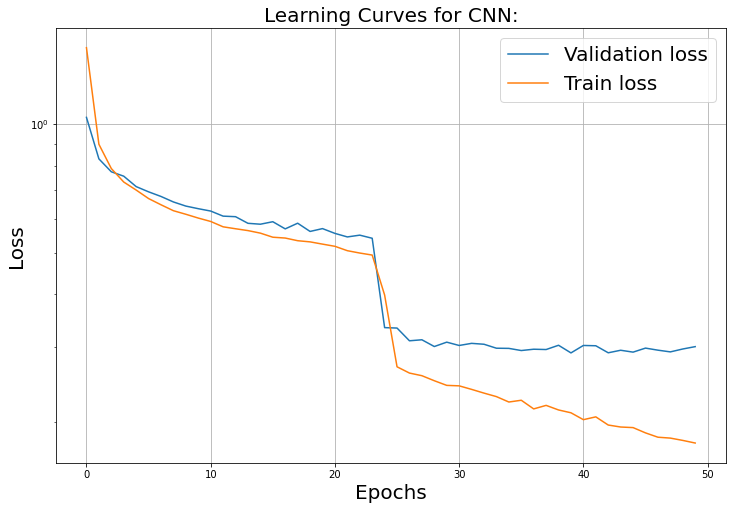

In [ ]:
plot_learningcurves(train_loss, test_loss)

The confusion matrix of the best model reflects my expectations. The Convolutional Neural Network is most of the time able to correctly recognize the labels of each data sample.

The main source of mistakes comes from class 6 ("shirt"), which can be sometimes confused by the network and interpreted as class 0 ("t-shirt") and vice versa. 

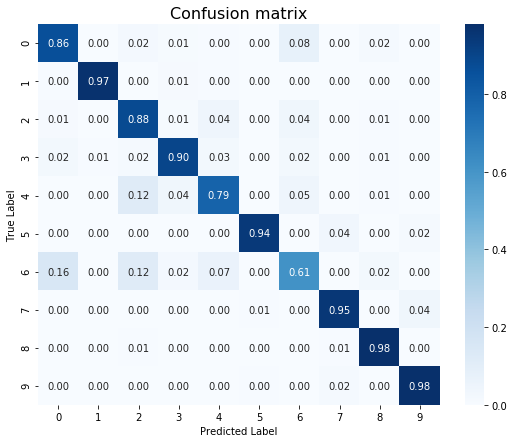

In [ ]:
#best_params = ChainMap(best_arch_params,best_learn_params)
plot_confusion_matrix(NN,test_dataloader,test_dataset,best_params)

## 2.8) Visualization

The last section of the notebook is dedicated to visualize the main features of the Convolutional Neural Network.

### 2.8.1) Weight Histograms

Here's the representation of the distribution of the weights in the first and second linear layers.



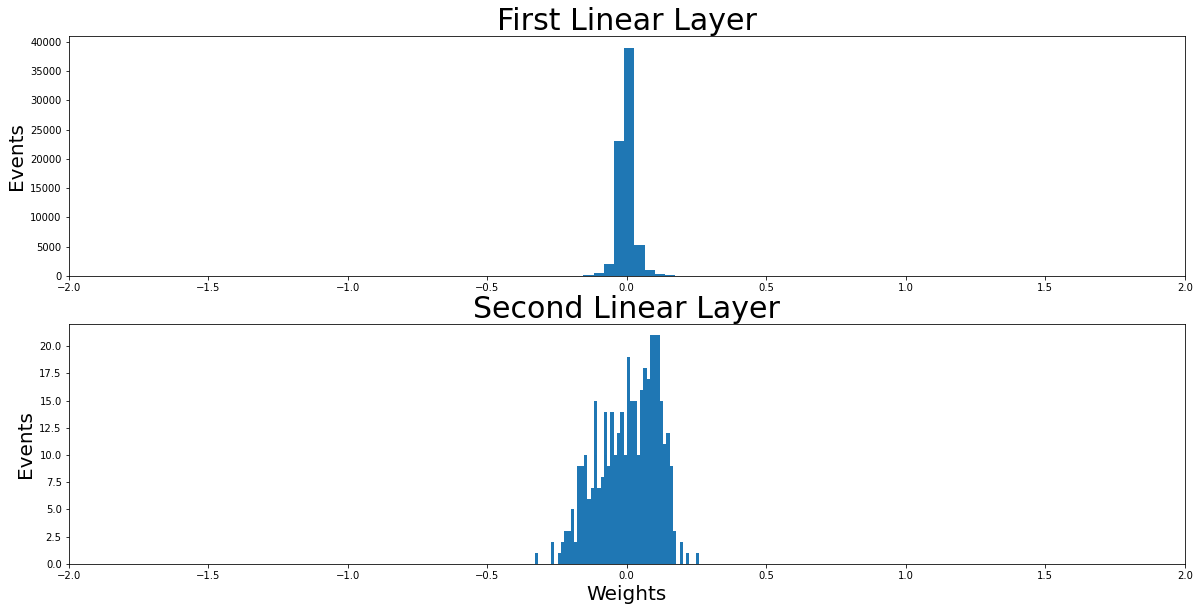

In [29]:
#First linear layer
weights_fc1 = NN.linear[0].weight.data.cpu().numpy().flatten()
#Second linear layer
weights_fc2 = NN.linear[2].weight.data.cpu().numpy().flatten()

# Weights histogram
plt.figure(figsize=(20, 15))
plt.subplot(311)
plt.hist(weights_fc1, 20)
plt.ylabel('Events',fontsize=20)
plt.xlim(-2,2)
plt.title("First Linear Layer",fontsize=30)
plt.subplot(312)
plt.title("Second Linear Layer",fontsize=30)
plt.hist(weights_fc2, 50)
plt.ylabel('Events',fontsize=20)
plt.xlabel('Weights',fontsize=20)
plt.xlim(-2,2)
plt.show()

### 2.8.2) Activation Profiles

Visualizing the Activation profiles is a useful exercise to have a feeling about the level of information available at different depths in the Neural Network.

As we can see from the images below, at the first convolutional layer we can still recognize the shapes of the input object and its different features. The more we go deep into the NN structure, the less the images are human readable.

This is due to the fact that each convolutional layer is in some way "summarizing" the previous layer informations by scanning the images with different kernels.

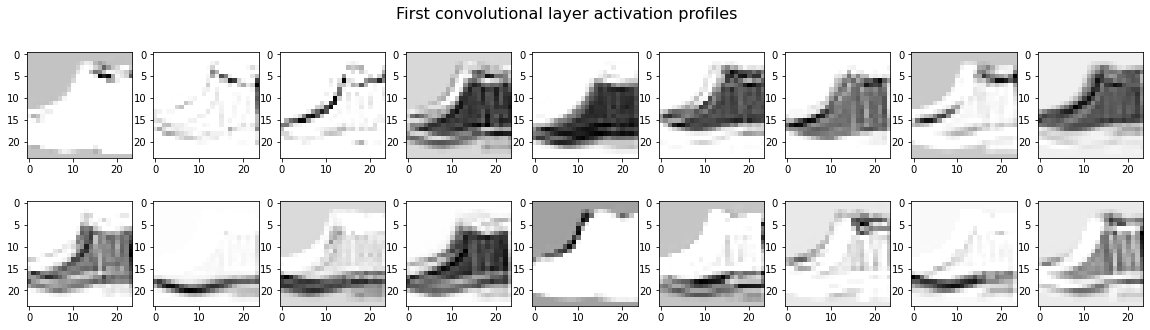

In [30]:
def get_activation(layer, input, output):
    global activation
    activation = torch.relu(output)

### Register hook  
hook_handle_conv1 = NN.conv[0].register_forward_hook(get_activation)

### Analyze activations
NN.to(device).eval()
inputs = torch.utils.data.DataLoader(test_dataset, batch_size = 1, shuffle = True)

with torch.no_grad():
    for inp in inputs:
        x_batch = inp[0].to(device)
        y = NN(x_batch)
        out = activation

conv1_act = out.cpu().numpy()


hook_handle_conv1.remove()

plt.figure(figsize=(20,5))
for i in range(18):
    plt.subplot(2,9,i+1)
    plt.imshow(conv1_act[0,i,:,:], cmap='Greys')
plt.suptitle('First convolutional layer activation profiles', size=16)
plt.show()

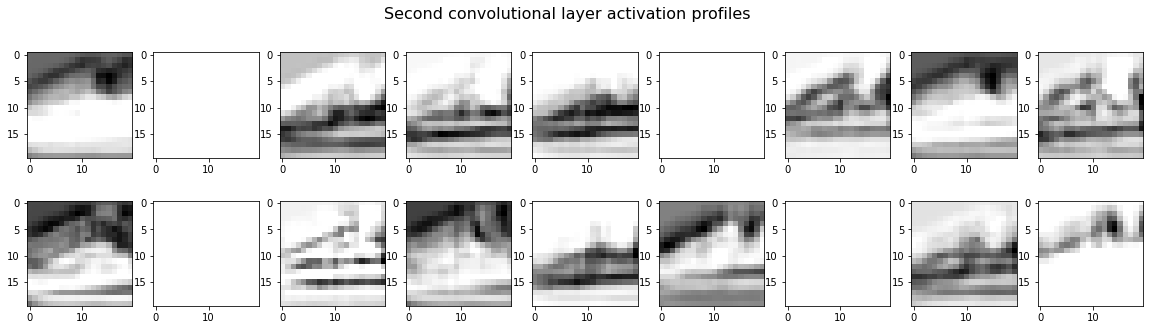

In [31]:
### Register hook  
hook_handle_conv2 = NN.conv[2].register_forward_hook(get_activation)

### Analyze activations
NN.to(device).eval()
inputs = torch.utils.data.DataLoader(test_dataset, batch_size = 1, shuffle = True)

with torch.no_grad():
    for inp in inputs:
        x_batch = inp[0].to(device)
        y = NN(x_batch)
        out = activation

conv2_act = out.cpu().numpy()


hook_handle_conv2.remove()

plt.figure(figsize=(20,5))
for i in range(18):
    plt.subplot(2,9,i+1)
    plt.imshow(conv2_act[0,i,:,:], cmap='Greys')
plt.suptitle('Second convolutional layer activation profiles', size=16)
plt.show()

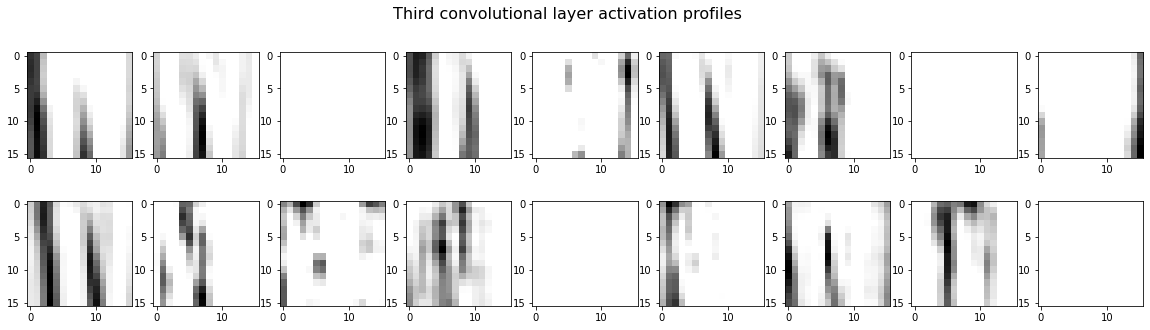

In [32]:
### Register hook  
hook_handle_conv3 = NN.conv[4].register_forward_hook(get_activation)

### Analyze activations
NN.to(device).eval()
inputs = torch.utils.data.DataLoader(test_dataset, batch_size = 1, shuffle = True)

with torch.no_grad():
    for inp in inputs:
        x_batch = inp[0].to(device)
        y = NN(x_batch)
        out = activation

conv3_act = out.cpu().numpy()


hook_handle_conv3.remove()

plt.figure(figsize=(20,5))
for i in range(18):
    plt.subplot(2,9,i+1)
    plt.imshow(conv3_act[0,i,:,:], cmap='Greys')
plt.suptitle('Third convolutional layer activation profiles', size=16)
plt.show()

### 2.8.3) Receptive Fields

In the below figures, the shapes of the different filters applied at each convolutional layer are reported.

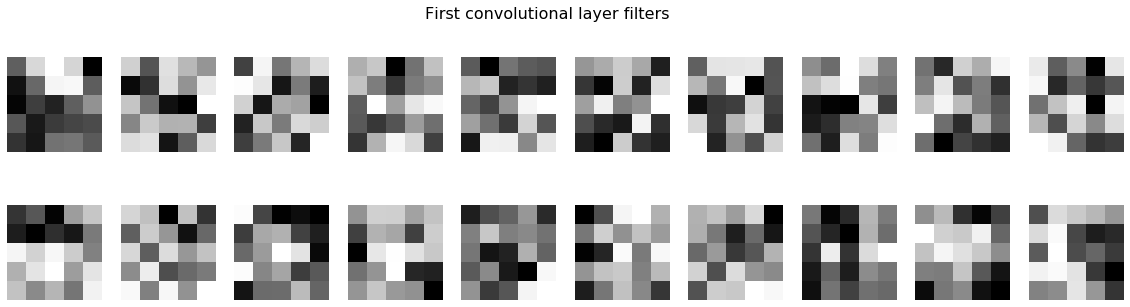

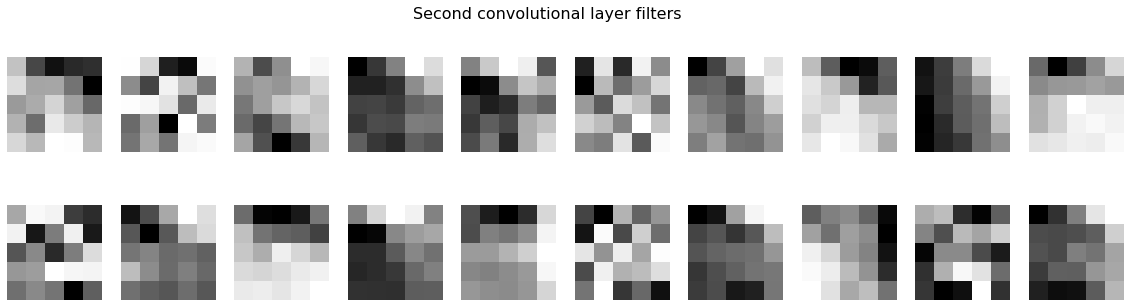

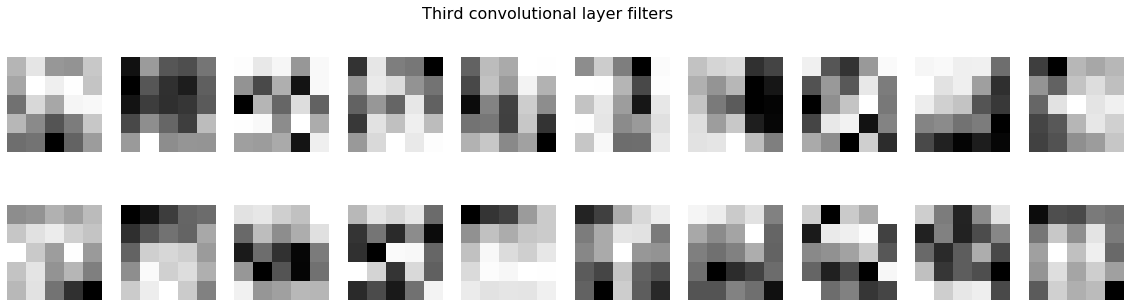

In [ ]:
#First convolutional layer
weights_conv1 = NN.conv[0].weight.data.cpu().numpy()

plt.figure(figsize=(20,5))
for i in range(20):
    plt.subplot(2,10,i+1)
    plt.imshow(weights_conv1[i, 0, :, :], cmap='Greys')
    plt.axis('off')
plt.suptitle('First convolutional layer filters',size=16)
plt.show()
    
#Second convolutional layer
weights_conv2 = NN.conv[2].weight.data.cpu().numpy()

plt.figure(figsize=(20,5))
for i in range(20):
    plt.subplot(2,10,i+1)
    plt.imshow(weights_conv2[i, 0, :, :], cmap='Greys')
    plt.axis('off')
plt.suptitle('Second convolutional layer filters',size=16)
plt.show()

#Third convolutional layer
weights_conv3 = NN.conv[4].weight.data.cpu().numpy()

plt.figure(figsize=(20,5))
for i in range(20):
    plt.subplot(2,10,i+1)
    plt.imshow(weights_conv3[i, 0, :, :], cmap='Greys')
    plt.axis('off')
plt.suptitle('Third convolutional layer filters',size=16)
plt.show()